In [20]:
import sys
import os
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

In [21]:
sys.path.append(os.path.abspath(".."))
from scr.utils import Log1pImputer, RatioInteractionImputer
from scr.validator import Validator

In [22]:
pipeline = pickle.load(open("../models/log_reg_pipeline.pkl", 'rb'))
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'marital_status',
                                                   'education_level',
                                                   'employment_status',
                                                   'loan_purpose']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strat...
                                                  Pipeline(steps=[('log1p',
                                                                   Log1pImputer())]),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'loan_amount']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['annual_income',
                                                   'debt_to_income_ratio',
                                                   'credit_score',
                                                   'loan_amount',
                                                   'interest_rate'])],
                                   verbose_feature_names_out=False)),
                ('model', LogisticRegression(max_iter=500))])

In [23]:
train_csv_path = "../data/train.csv"
frame = pd.read_csv(train_csv_path, index_col=0)
X = frame.drop("loan_paid_back", axis=1)
y = frame["loan_paid_back"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
validator = Validator(pipeline[0], pipeline[1], X_train, y_train)

### Stability validation ###

In [25]:
validator.stability_test(pipeline[1], X_val, y_val, 7)

Cross validation: 
 count    7.0000
mean     0.9110
std      0.0029
min      0.9054
25%      0.9101
50%      0.9114
75%      0.9131
max      0.9136
dtype: float64


Low standard deviation ensures the stability of the models.

### Distribution test ### 
Test checking data drift between the test and training sets. - model shouldn't be able to distinct data

*In this task is useless because the data are syntetic but in real production/buisness problem, checking data drift is quite important

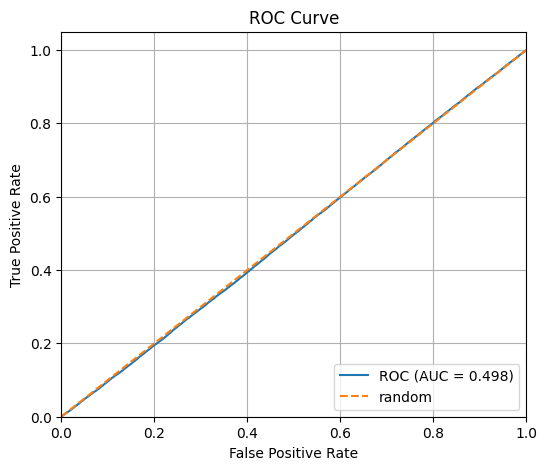

In [26]:
class_0 = pd.read_csv("../data/train.csv", index_col=0).drop("loan_paid_back", axis=1)
class_1 = pd.read_csv("../data/test.csv", index_col=0)
validator.distribution_test(class_0, class_1)

### Sanity validation ### 
Labels of data will be permuted to check if there is a leakage - results should be random 

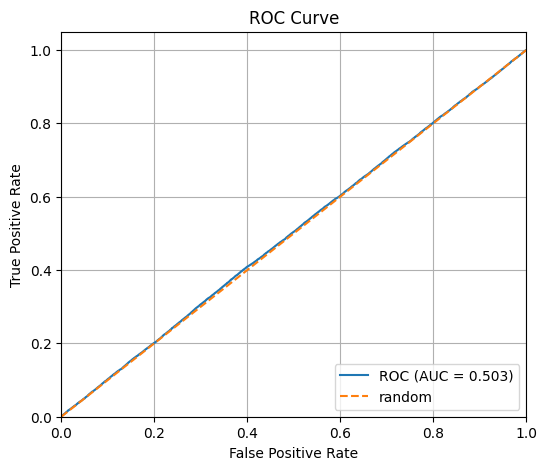

In [27]:
validator.sanity_test(X_val, y_val)

### Robustness validation ###
How the model will behave after adding noise

##### Gaussian noise #####

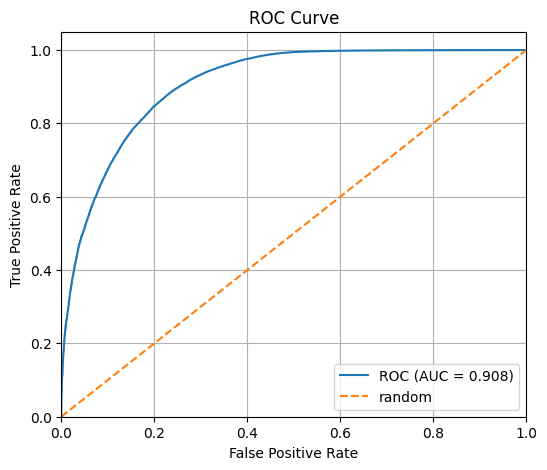

In [28]:
validator.robustness_test(X_val, y_val, noise="gaussian")

##### Quantization #####

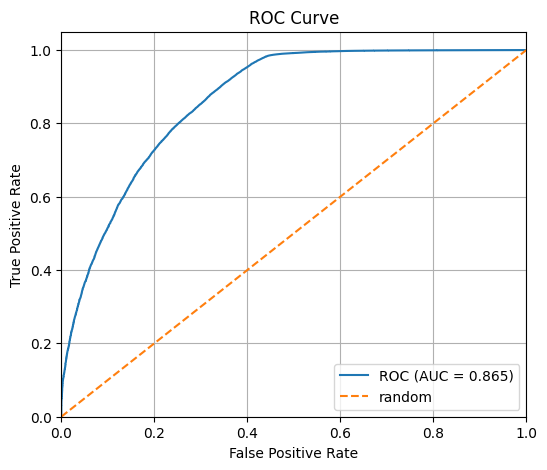

In [29]:
validator.robustness_test(X_val, y_val, noise="quantization", delta=1)

### Semantic validation (Creme de la creme) ###

##### Error analysis #####

Decile and Partial ROC

In [ ]:
y_pred = validator.full_pipeline.predict_proba(X_val)[:,1]
validator.semantic_test(y_val, y_pred, type="error")

Base rate:  0.798
        positive_rate  count  avg_score
decile                                 
9               0.996  11880      0.991
8               0.986  11880      0.979
7               0.976  11880      0.969
6               0.961  11880      0.958
5               0.937  11879      0.943
4               0.906  11880      0.921
3               0.867  11880      0.882
2               0.784  11880      0.802
1               0.535  11880      0.492
0               0.032  11880      0.053
Partial AUC (FPR <= 5%): 0.37320024031997756


The monotonic ranking works globally.The top deciles are highly enriched, the model segregates positive observations very well, and the bottom decile, the model also identifies negatives well. Diff from decile 1 -> 0 (0.535 -> 0.032) shows clear differences in scores. The model only captures 37% of positives in region FPR <= 5%. Model is not ideal for extreme selection

##### Calibration + separation #####

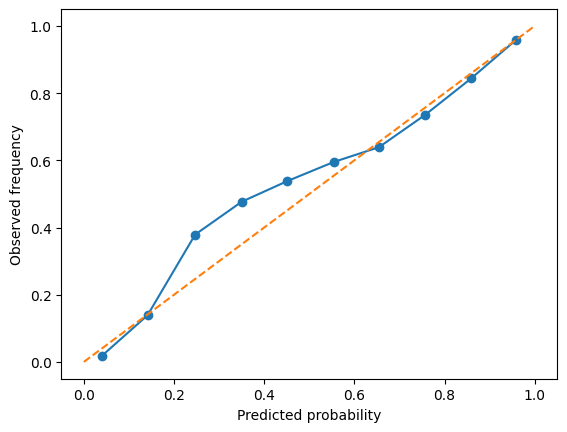

Brier score: 0.0770243013189087


In [31]:
validator.semantic_test(y_val, y_pred, type="calibration")

Globally the model is well calibrated (Brier account both calibration and separation)

##### Score distribution #####

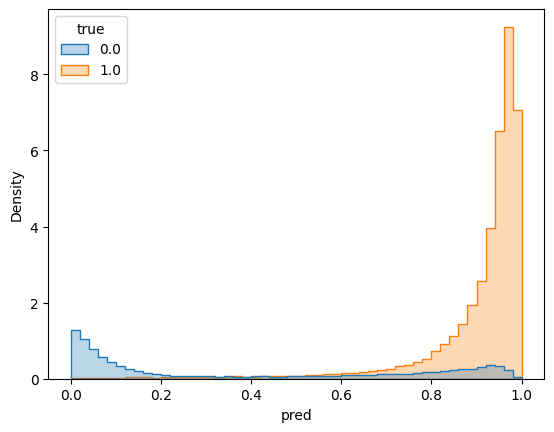

In [32]:
validator.semantic_test(y_val, y_pred, type="score_distributions")

Very good class separation. Class 1 is heavily concentrated in high scores, and class 0 is mostly in low scores, but with a suspicious tail towards high scores (coherent with partial ROC). 
there is odd tail in 0 class, it could be overfit

Good global ranking with working global separation. There is a problem with selection in extreme regions (class 0 tail).
Possible explanations for the tail:
--Nonlinearity of the boundary + small segment of difficult negatives.
- Hidden segmentation variable
- Regularization too weak
- Label noise / Outliers 